# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
Ks = np.array([0.2, 0.8])
round(-np.sum(Ks*np.log(Ks)), 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
Q = np.sum(Ks*(1-Ks)) - 0.8*1*(1-1) - 0.2*1*(1-1)
round(Q, 2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
preds_node = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
np.mean(preds_node)

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [8]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    X = np.asarray(feature_vector)
    y = np.asarray(target_vector)
    if feature_type == 'real':
        X_sorted = np.sort(X)
        y_sorted = np.sort(y)
        thresholds = (X_sorted[:-1] + X_sorted[1:]) / 2
        if len(thresholds) == 0:
            return np.array([]), np.array([]), None, None
        n = len(y_sorted)
        indices = np.arange(1, n)
        
        if task == 'classification':
            
            classes, y_ind = np.unique(y_sorted, return_inverse=True)
            n_classes = len(classes)
            y_one_hot = np.zeros((n, n_classes))
            y_one_hot[np.arange(n), y_ind] = 1
            
            l_counts = np.cumsum(y_one_hot[:-1], axis=0)
            r_counts = y_one_hot.sum(axis=0) - l_counts
            l_size = indices
            r_size = n - indices
            l_gini = 1 - np.sum((l_counts / l_size[:, None])**2, axis=1)
            r_gini = 1 - np.sum((r_counts / r_size[:, None])**2, axis=1)
            info = (l_size / n) * l_gini + (r_size / n) * r_gini
            ginis = info

        elif task == 'regression':
            
            y_cumsum = np.cumsum(y_sorted)
            y_cumsum_sqrt = np.cumsum(y_sorted**2)
            l_count = indices
            r_count = n - indices
            l_sum = y_cumsum[:-1]
            r_sum = y_cumsum[-1] - l_sum
            l_sum_sqrt = y_cumsum_sqrt[:-1]
            r_sum_sqrt = y_cumsum_sqrt[-1] - l_sum_sqrt
            
            l_var = (l_sum_sqrt - (l_sum**2) / l_count) / l_count
            r_var = (r_sum_sqrt - (r_sum**2) / r_count) / r_count
            info = (l_count / n) * l_var + (r_count / n) * r_var
            ginis = info
            
        else:
            raise ValueError("this is not a proper task")
    
    elif feature_type == 'categorical':
        cats = np.unique(X)
        thresholds = cats
        ginis = []

        for cat in cats:
            l_mask = X == cat
            r_mask = ~l_mask
            if l_mask.sum() == 0 or r_mask.sum() == 0:
                continue 
            if task == 'classification':
                l_gini = 1 - np.sum((np.unique(y[l_mask], return_counts=True)[1]/np.unique(y[l_mask], return_counts=True)[1].sum()) ** 2)
                r_gini = 1 - np.sum((np.unique(y[r_mask], return_counts=True)[1]/np.unique(y[r_mask], return_counts=True)[1].sum()) ** 2)
            elif task == 'regression':
                l_gini = np.var(y[l_mask])
                r_gini = np.var(y[r_mask])
            else:
                raise ValueError("this is not a proper task")
            info = (l_mask.sum() / len(y)) * l_gini + (r_mask.sum() / len(y)) * r_gini
            ginis.append(info)
        ginis = np.array(ginis)
    
    else:
        raise ValueError("such type of feature doesn't exist:(")
    if len(ginis) == 0:
        return np.array([]), np.array([]), None, None   
    best = np.argmin(ginis)
    return thresholds, ginis, thresholds[best], ginis[best]

Эту функцию можно протестировать на датасете `California`.

In [9]:
from sklearn.datasets import fetch_california_housing

In [10]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [11]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [12]:
find_best_split(X, y, task = "regression")

(array([[-1.22225000e+02,  9.97845008e-01,  2.33269869e+00, ...,
          2.94400000e+01,  3.94300000e+01,  1.36150000e+03],
        [-1.22230000e+02,  1.02266341e+00,  2.45605086e+00, ...,
          2.94250000e+01,  4.49300000e+01,  1.44850000e+03],
        [-1.22245000e+02,  1.07325284e+00,  2.67510255e+00, ...,
          3.78500000e+01,  5.20000000e+01,  5.27000000e+02],
        ...,
        [-1.21215000e+02,  1.21794093e+00,  2.12840000e+00, ...,
          1.75000000e+01,  3.94600000e+01,  6.81500000e+02],
        [-1.21270000e+02,  1.14600607e+00,  1.78360000e+00, ...,
          1.75000000e+01,  3.94300000e+01,  8.74000000e+02],
        [-1.21280000e+02,  1.16709196e+00,  2.12790000e+00, ...,
          1.70000000e+01,  3.94000000e+01,  1.06400000e+03]]),
 array([1.33137195, 1.33119359, 1.33101521, ..., 1.33030108, 1.33071752,
        1.33113393]),
 array([-117.065     ,    1.17228024,    1.96949574,    4.1715    ,
           6.28733215,   17.        ,   33.03      ,  691.        

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [13]:
our_split = find_best_split(X['MedInc'], y, task = 'regression')
criteria = our_split[1]
threshold = our_split[0]

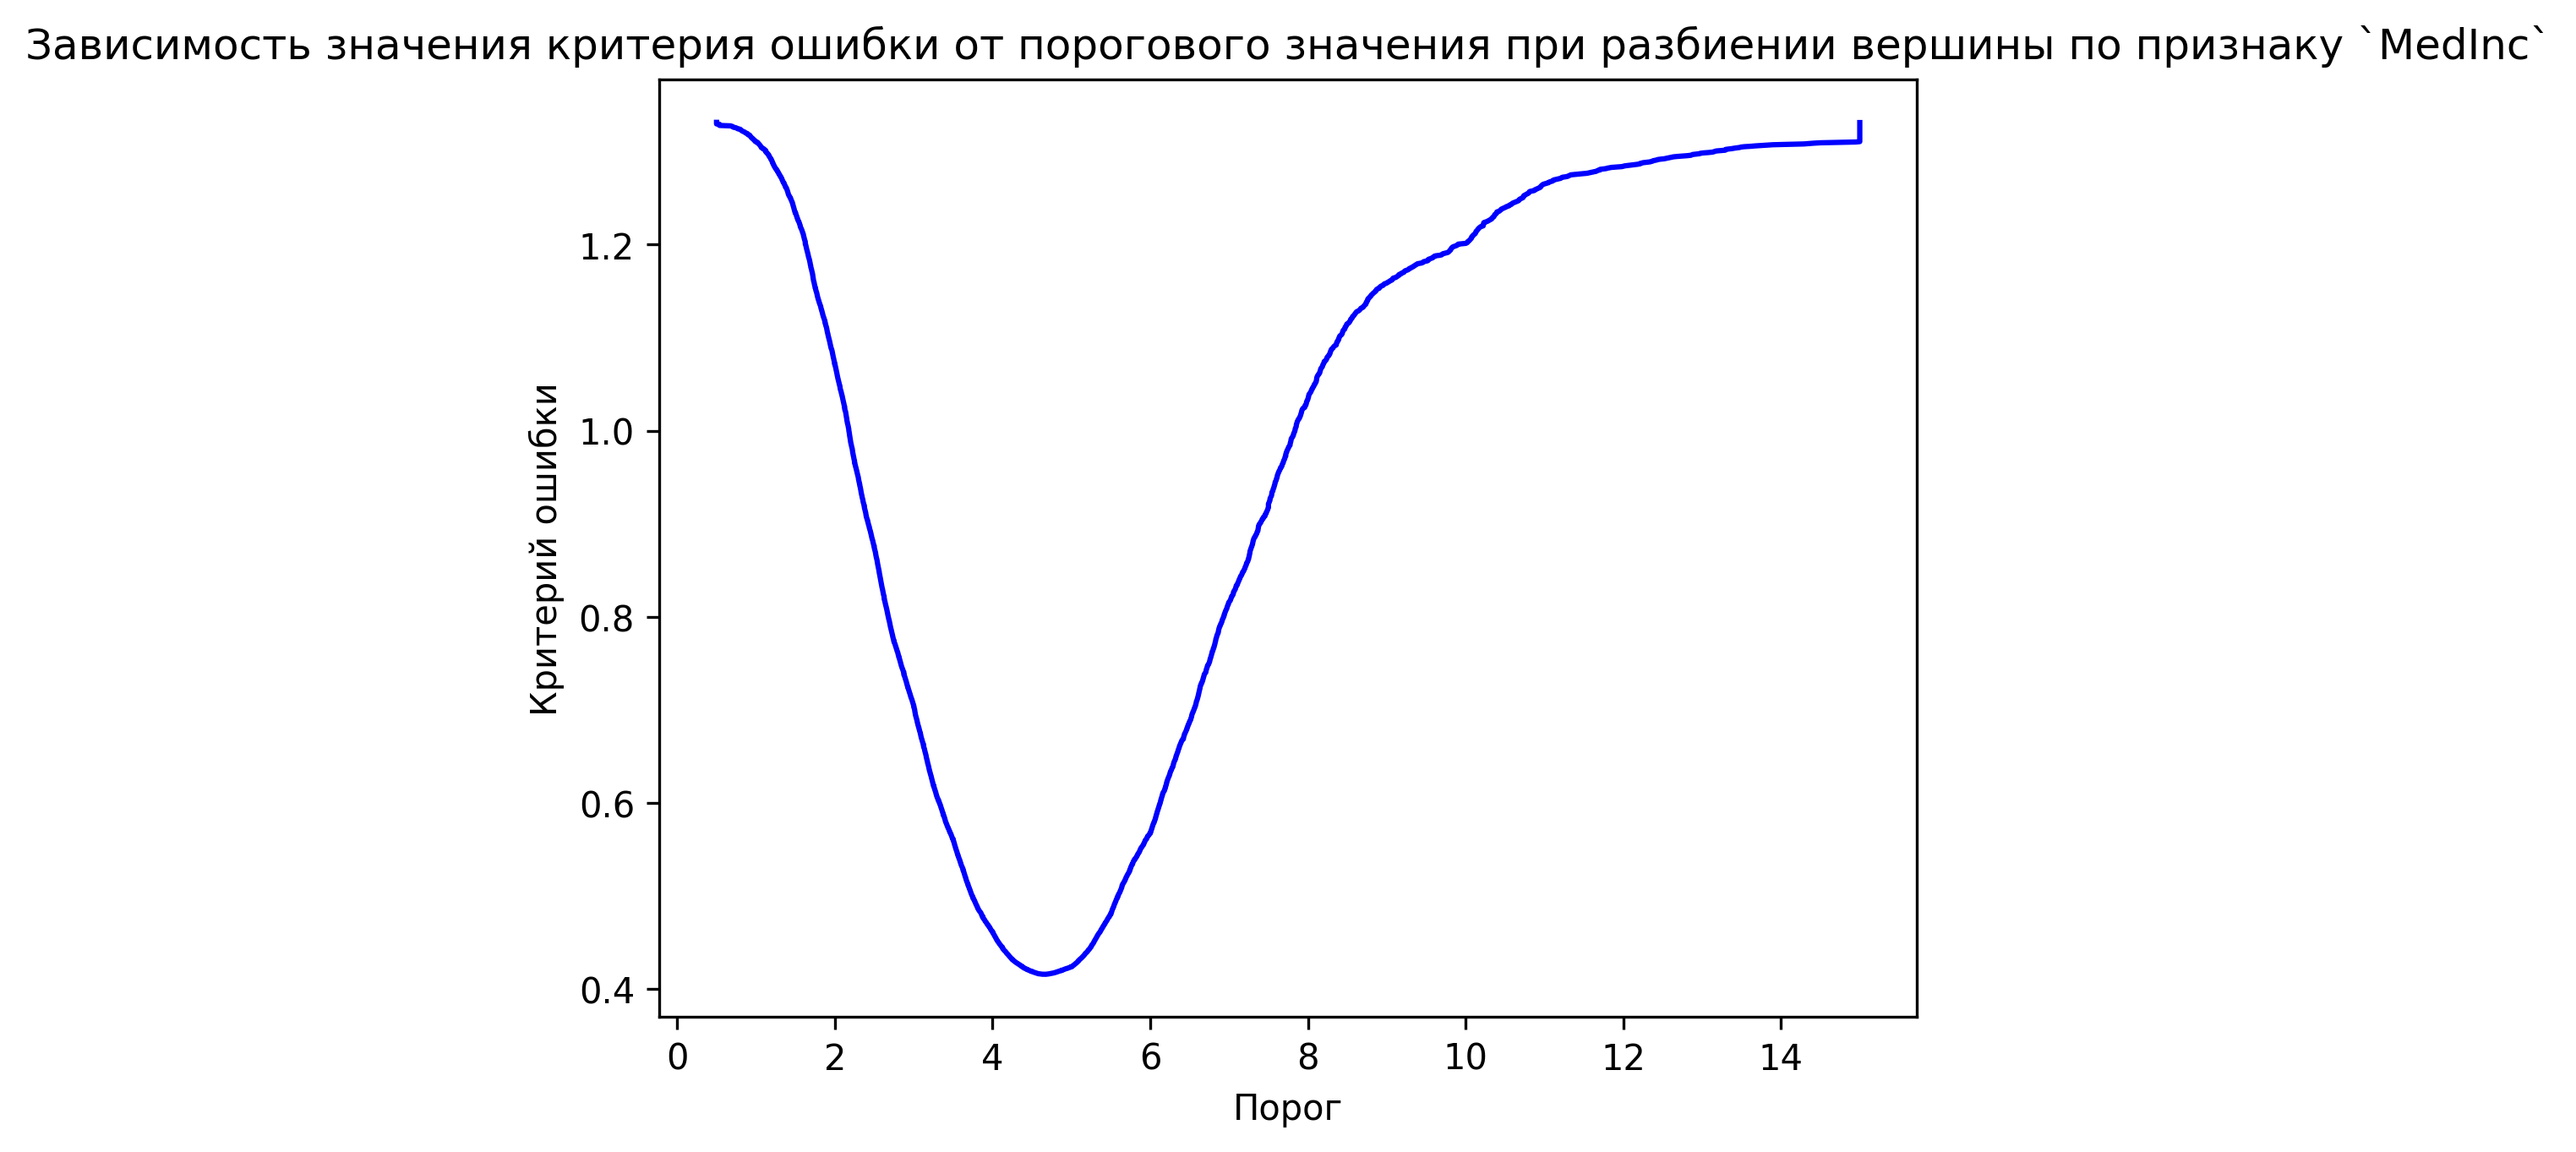

In [14]:
plt.figure(dpi = 300)
plt.plot(threshold, criteria, 'blue')
plt.xlabel('Порог')
plt.ylabel('Критерий ошибки')
plt.title('Зависимость значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`');

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [15]:
our_split[-2]

4.6528

Таким образом, лучший предикат первой вершины - это `X['MedInc'] > 4.6528`

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [16]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        #делаем счетчик, который будет сохранять, сколько раз по признаку делалось разбиение для определения его важности
        if not 'feature_best' in self._feature_importances:
            self._feature_importances[feature_best] = 1
        else:
            self._feature_importances[feature_best] += 1
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
            if x[feature] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature] == "categorical":
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("There is unknown feature type")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = np.asarray(X)
        y = np.asarray(y)
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

    def inputation(self, X: np.ndarray) -> np.ndarray: #способ обработки пропусков
        X_nans = X.copy()
        for feature_idx, feature_type in enumerate(self._feature_types):
            col = X[:, feature_idx]
            if feature_type == 'real': #если признак вещественный, заполнем медианными значениями
                mask = ~np.isnan(col)
                col[np.isnan(col)] = np.median(col[~np.isnan(col)])
                X_nans[:, feature_idx] = col
            else: #если признак категориальный, заполняем модой
                col_series = pd.Series(col)
                col = col_series.fillna(col_series.mode(dropna=True)[0]).values
                X_nans[:, feature_idx] = col
        return X_nans

    #сделаем функцию, которая будет возвращать сохраненные ранее важности признаков:
    def get_feature_importances(self) -> dict:
        return self._feature_importances

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

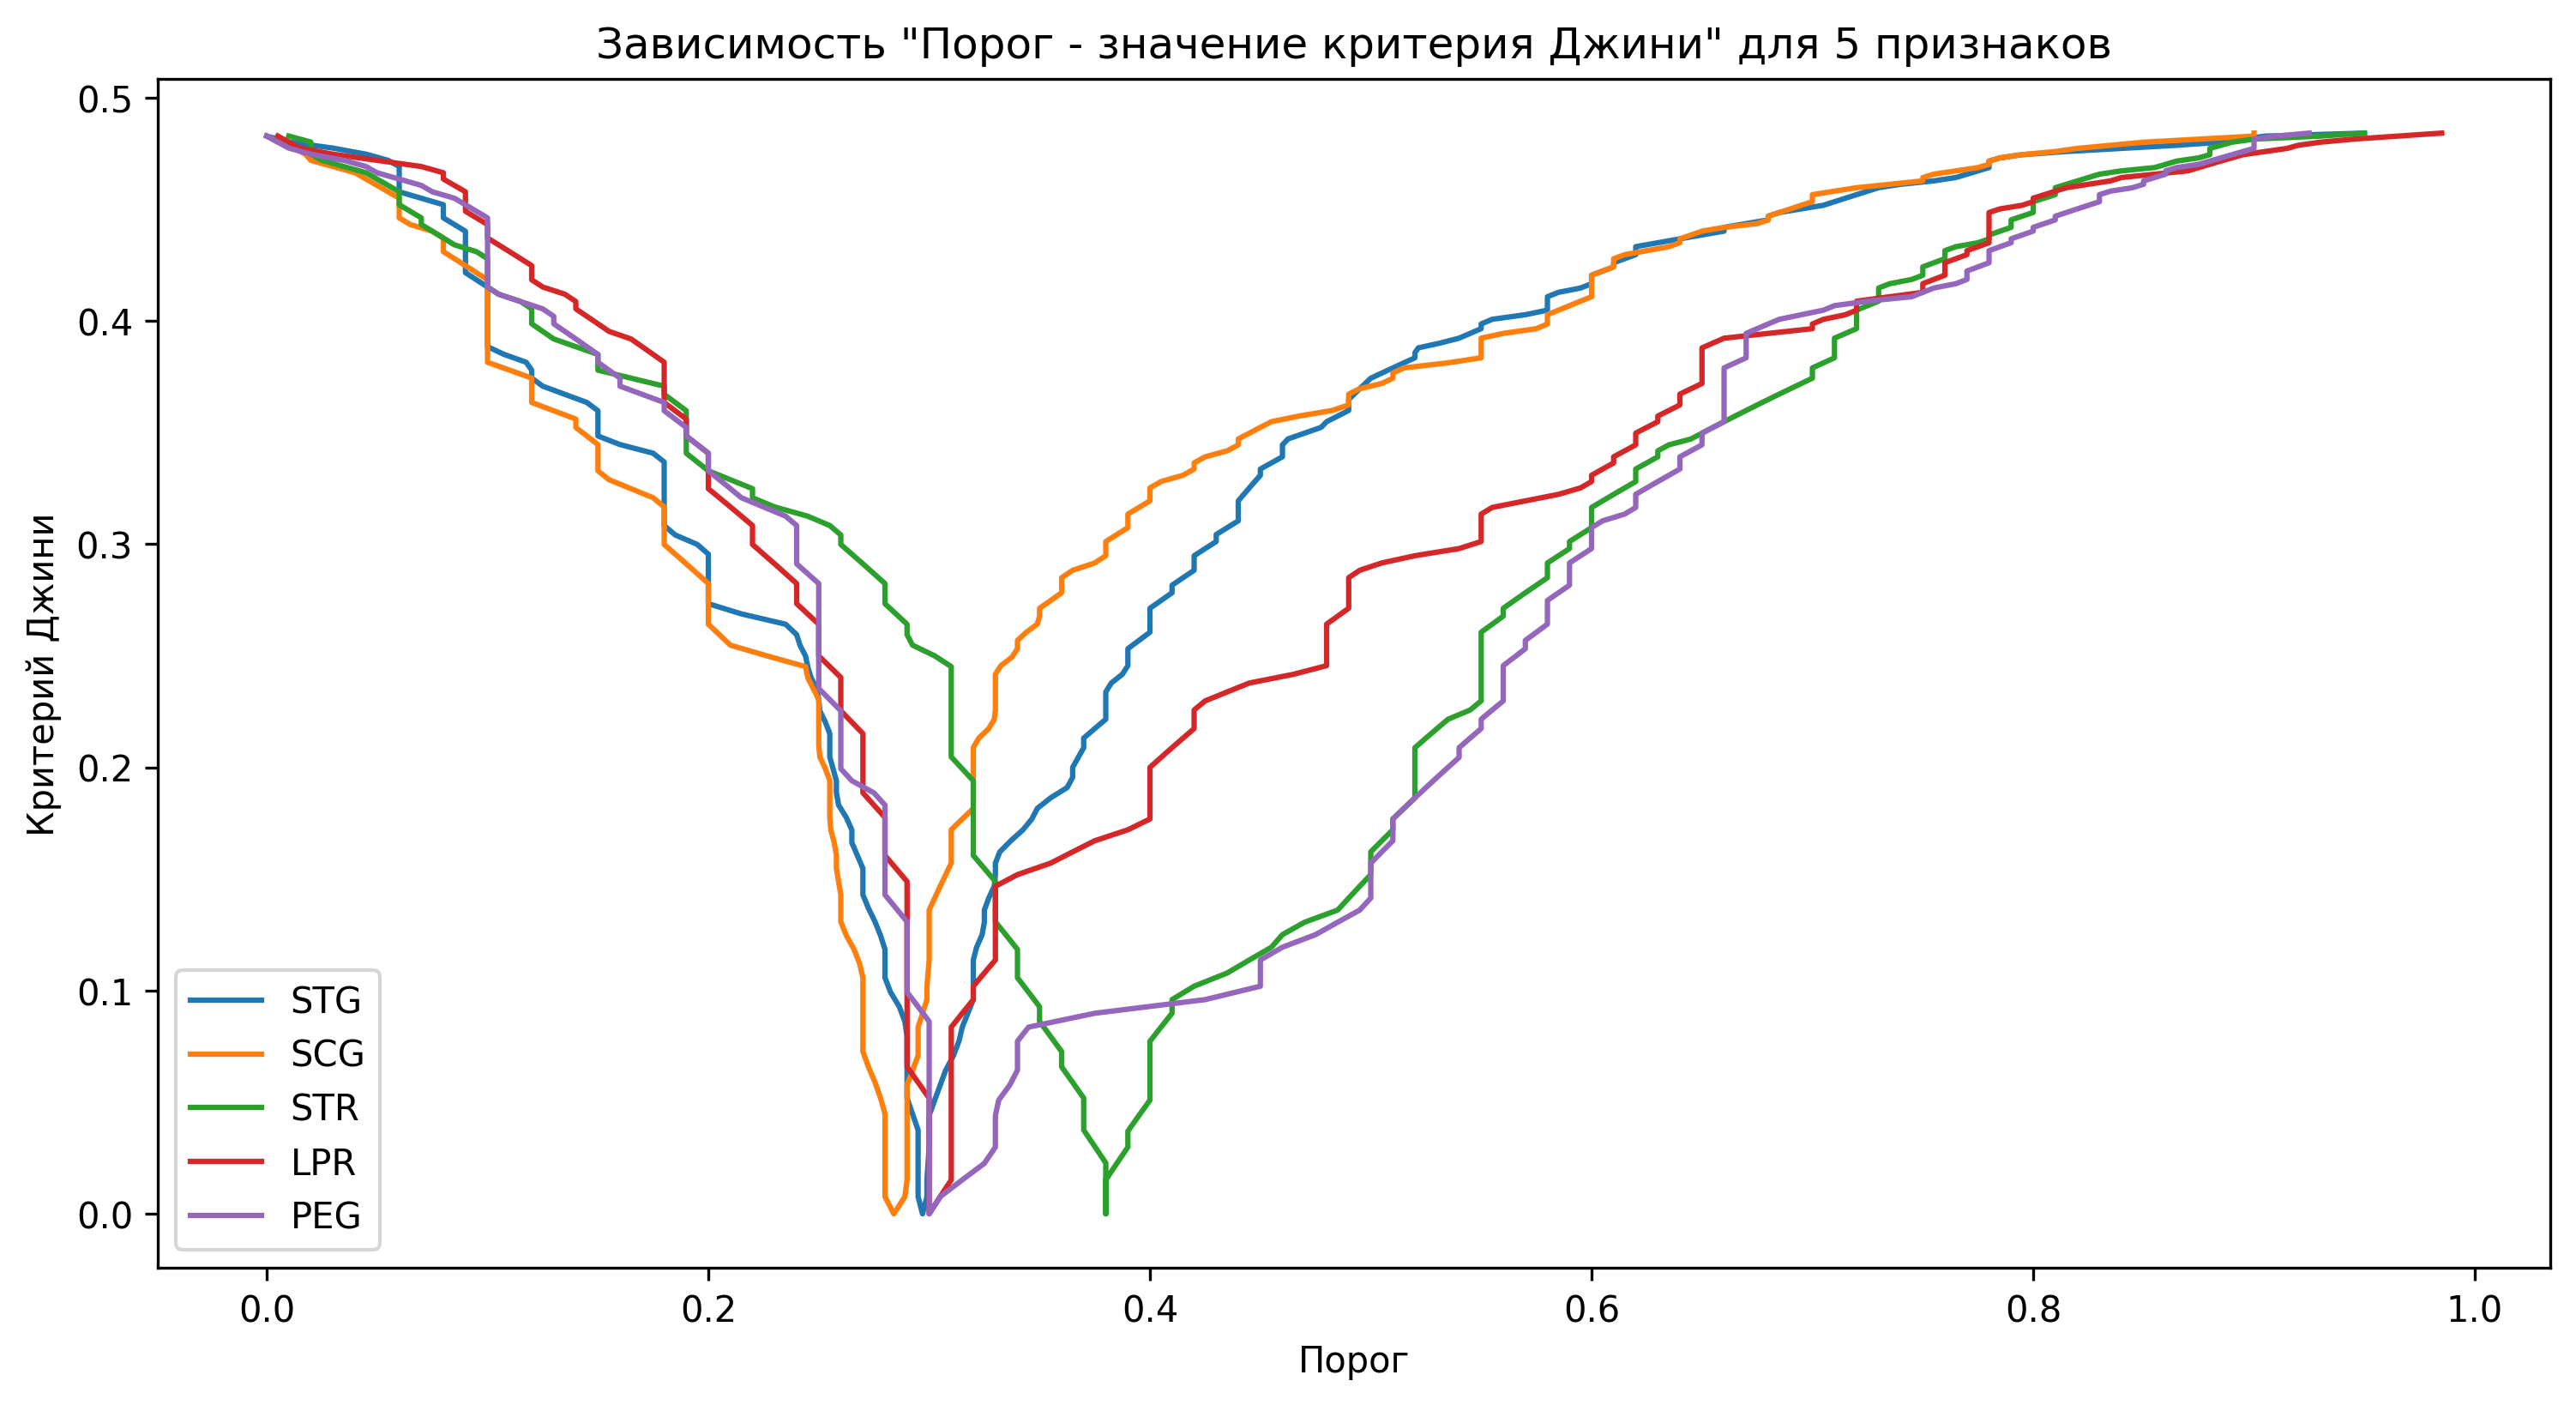

In [17]:
df = pd.read_csv("students.csv")
y = df['UNS']
X = df.drop(['UNS', 'Unnamed: 0'], axis = 1)

#return thresholds, info, thresholds[best], info[best]

plt.figure(figsize = (12, 6), dpi = 300)
for i in X.columns:
    p, q, _, _, = find_best_split(X[i], y, task = 'classification')
    plt.plot(p, q, label = i)
plt.legend()
plt.xlabel('Порог')
plt.ylabel('Критерий Джини')
plt.title('Зависимость "Порог - значение критерия Джини" для 5 признаков');

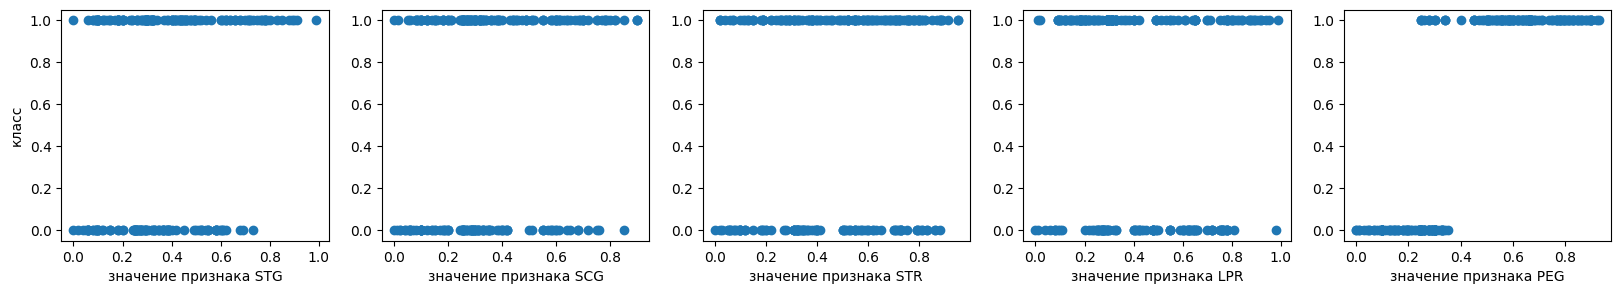

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(20, 3))
for i in range(5):
    axs[i].scatter(X[X.columns[i]], y, label = X.columns[i])
    axs[i].set_xlabel(f'значение признака {X.columns[i]}')
axs[0].set_ylabel('класс');

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Исходя из кривых значений критерия Джини, разбиение нужно проводить по признаку SCG, так как у него меньше всего значение порога (разбиение будет минимальным).
Это не согласуется с оценкой диаграмм рассеяния - судя по ним, разбиение лучше всего делать по признаку PEG, так как у него два класса реже всего могут принимать одинаковые значения

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [19]:
df = pd.read_csv("agaricus-lepiota.data")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in df.columns:
    df[column] = le.fit_transform(df[column])

In [20]:
y = df['p']
X = df.drop('p', axis = 1)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=45)

In [67]:
dt = DecisionTree(feature_types = ["categorical"] * X_train.shape[1])

In [68]:
dt.fit(np.asarray(X_train), np.asarray(y_train))

In [69]:
y_pred = dt.predict(np.asarray(X_test))

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9970457902511078

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [629]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [630]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

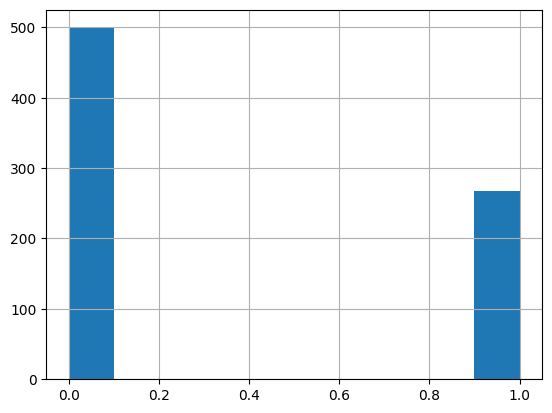

In [631]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [632]:
y = data['Outcome']
X = data.drop('Outcome', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = np.random.seed(40))
X_train_train, X_train_eval, y_train_train, y_train_eval = train_test_split(
    X_train, y_train, test_size = 0.3, random_state = np.random.seed(40))

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [633]:
depths = [1, 3, 6, 10]
samples = [1, 2, 3, 4]

for max_depth in depths:
    for min_samples_leaf in samples:
        dtc = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
        dtc.fit(X_train_train, y_train_train)
        y_pred = dtc.predict(X_train_eval)
        print(f'Maximal depth: {max_depth}, minimal samples in leaf: {min_samples_leaf}, f1-score: {f1_score(y_train_eval, y_pred)}')

Maximal depth: 1, minimal samples in leaf: 1, f1-score: 0.49019607843137253
Maximal depth: 1, minimal samples in leaf: 2, f1-score: 0.49019607843137253
Maximal depth: 1, minimal samples in leaf: 3, f1-score: 0.49019607843137253
Maximal depth: 1, minimal samples in leaf: 4, f1-score: 0.49019607843137253
Maximal depth: 3, minimal samples in leaf: 1, f1-score: 0.48
Maximal depth: 3, minimal samples in leaf: 2, f1-score: 0.48
Maximal depth: 3, minimal samples in leaf: 3, f1-score: 0.48
Maximal depth: 3, minimal samples in leaf: 4, f1-score: 0.48
Maximal depth: 6, minimal samples in leaf: 1, f1-score: 0.5614035087719298
Maximal depth: 6, minimal samples in leaf: 2, f1-score: 0.5739130434782609
Maximal depth: 6, minimal samples in leaf: 3, f1-score: 0.5739130434782609
Maximal depth: 6, minimal samples in leaf: 4, f1-score: 0.65
Maximal depth: 10, minimal samples in leaf: 1, f1-score: 0.4778761061946903
Maximal depth: 10, minimal samples in leaf: 2, f1-score: 0.46296296296296297
Maximal depth

Наибольшее значение f1-меры было достигнуто при max_depth = 6 и min_samples_leaf = 4.

In [634]:
dtc = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 4)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print(f'accuracy on test:{accuracy_score(y_test, y_pred)}')
print(f'precision on test:{precision_score(y_test, y_pred)}')
print(f'recall on test:{recall_score(y_test, y_pred)}')
print(f'ROC-AUC on test:{roc_auc_score(y_test, y_pred)}')

accuracy on test:0.7186147186147186
precision on test:0.6714285714285714
recall on test:0.5280898876404494
ROC-AUC on test:0.683059028327267


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [635]:
bc = BaggingClassifier(n_estimators = 50)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
print(f'accuracy on test:{accuracy_score(y_test, y_pred)}')
print(f'precision on test:{precision_score(y_test, y_pred)}')
print(f'recall on test:{recall_score(y_test, y_pred)}')
print(f'ROC-AUC on test:{roc_auc_score(y_test, y_pred)}')

accuracy on test:0.7619047619047619
precision on test:0.7236842105263158
recall on test:0.6179775280898876
ROC-AUC on test:0.7350451020731128


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [638]:
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier()

param_test = {"max_depth": [1, 3, 6, 10], "min_samples_split": [2, 3, 4, 6]}

gsearch = GridSearchCV(
    estimator=rfc, param_grid=param_test, scoring="f1", n_jobs=-1, cv=5
)

gsearch.fit(X_train, y_train)

results_df = pd.DataFrame(gsearch.cv_results_)[["param_max_depth", "param_min_samples_split", "mean_test_score"]]

Наилучшее среднее качество дала пара значений max_depth = 10 и min_samples_split = 3

In [639]:
rfc = RandomForestClassifier(max_depth = 10, min_samples_split = 3)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'accuracy on test:{accuracy_score(y_test, y_pred)}')
print(f'precision on test:{precision_score(y_test, y_pred)}')
print(f'recall on test:{recall_score(y_test, y_pred)}')
print(f'ROC-AUC on test:{roc_auc_score(y_test, y_pred)}')

accuracy on test:0.7662337662337663
precision on test:0.7611940298507462
recall on test:0.5730337078651685
ROC-AUC on test:0.7301788257635702


Из трех построенных моделей **лучше** всего показал себя случайный лес, а **хуже** - дерево решений.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [645]:
auc_rocs = []
n = []
for i in range(1, 251, 2):
    rfc = RandomForestClassifier(n_estimators = i, max_depth = 10, min_samples_split = 3)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    auc_rocs.append(roc_auc_score(y_test, y_pred))
    n.append(i)

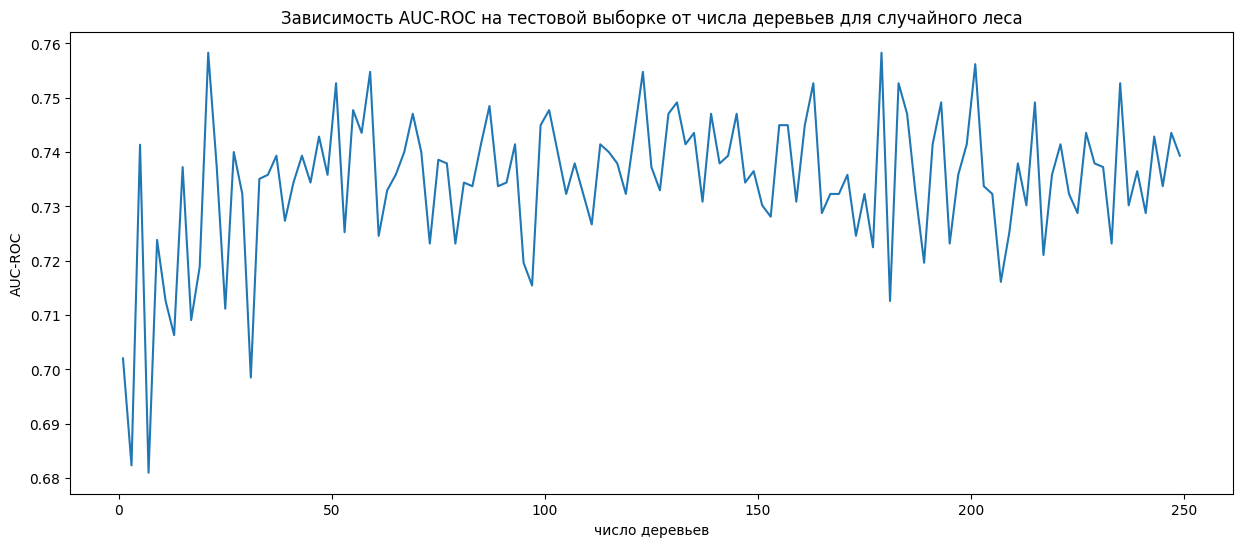

In [647]:
plt.figure(figsize = (15,6))
plt.plot(n, auc_rocs)
plt.xlabel('число деревьев')
plt.ylabel('AUC-ROC')
plt.title('Зависимость AUC-ROC на тестовой выборке от числа деревьев для случайного леса');

Можно сделать вывод, что качество случайного леса по мере увеличения числа деревьев сначала растет, но затем перестает улучшаться и начинает колебаться вокруг примерно одного и того же значения, хотя и довольно сильно.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

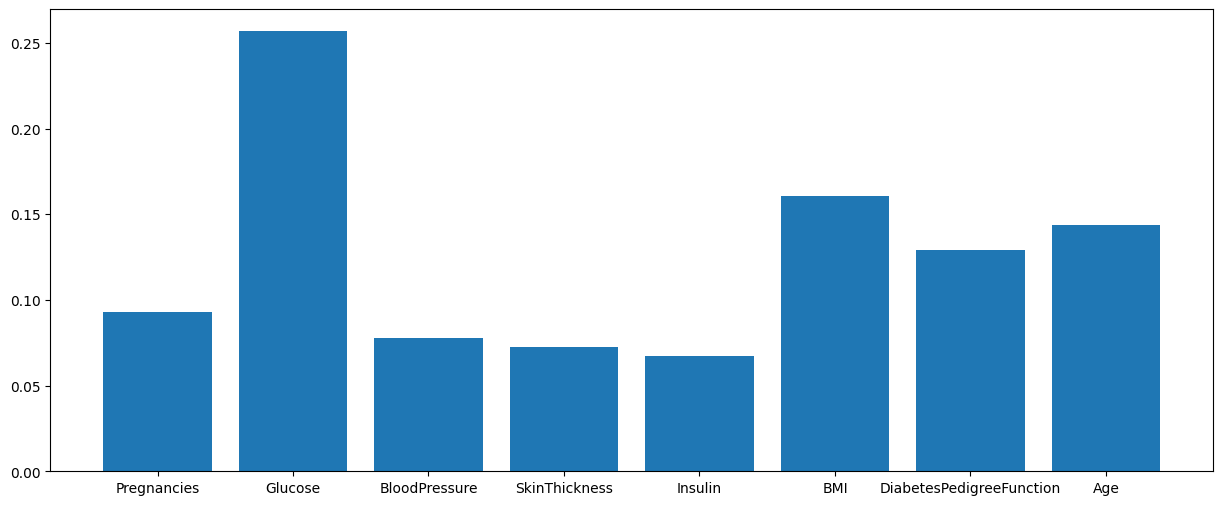

In [343]:
rfc = RandomForestClassifier(max_depth = 10, min_samples_split = 3)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
plt.figure(figsize = (15, 6))
plt.bar(rfc.feature_names_in_, rfc.feature_importances_);

Для определения диабета самым важным признаком оказался 'Glucose' - уровень глюкозы в плазме крови через 2 часа после взятия перорального теста на глюкозу (из описания датасета).